# Tutorial 3: A First Model

After getting a basic understanding of the data in the previous tutorial, we are ready to build the first AI model. In this notebook, we will build and evaluate a simple Random Forest model with the use of one feature extracted from the dataset - the top frequency per sample. We will evaluate our model, gain an understanding of the evaluation metric and submit our first results to the leaderboard!

**NOTE:** This notebook does not require a GPU instance.

## Setup

First, we need to import required libraries and functions. 

In [3]:
import matplotlib.pyplot as plt     # allows creation of insightful plots
import numpy as np                  # for performing calculations on numerical arrays
import pandas as pd                 # home of the DataFrame construct, _the_ most important object for Data Science
import seaborn as sns               # allows creation of insightful plots, but a bit prettier
import sys                          # Python system library needed to load custom functions
import torchaudio                   # library that will allow us to load the audio files
import os                           # for changing the directory

from scipy.fft import fft, fftfreq  # functions for calculating the fourier transform and frequencies from audio data
from tqdm.auto import tqdm          # library to display progress bar while doing apply on pandas dataframe

sys.path.append('../src')
pd.set_option('display.max_columns', None) # All the columns in a dataframe are shown 
tqdm.pandas()                       # integrate tqdm with Pandas
# line to render the plots under the code cell that created it
%matplotlib inline

from eda_utils import plot_spec     # functions to create plots for and from audio data
from gdsc_utils import PROJECT_DIR # our root directory
os.chdir(PROJECT_DIR) # changing our directory to root

## Data preparation

Let's start with loading the metadata file with the information about our dataset and use the first audio file as an example to illustrate how we want to extract the top frequency.

In [4]:
df_metadata = pd.read_csv('data/metadata.csv') # loading the metadata file
example_path = df_metadata.loc[0, 'path'] # getting the first path from the dataset
example_path

'data/train/Roeselianaroeselii_XC751814-dat028-019_edit1.wav'

Do you guys already miss some EDA work? Let us inspect the spectrogram of this file. We know already that the spectrogram contains information about time and frequency domains. From the plot, we will see how the different frequencies are present in our file across the duration of the recording.

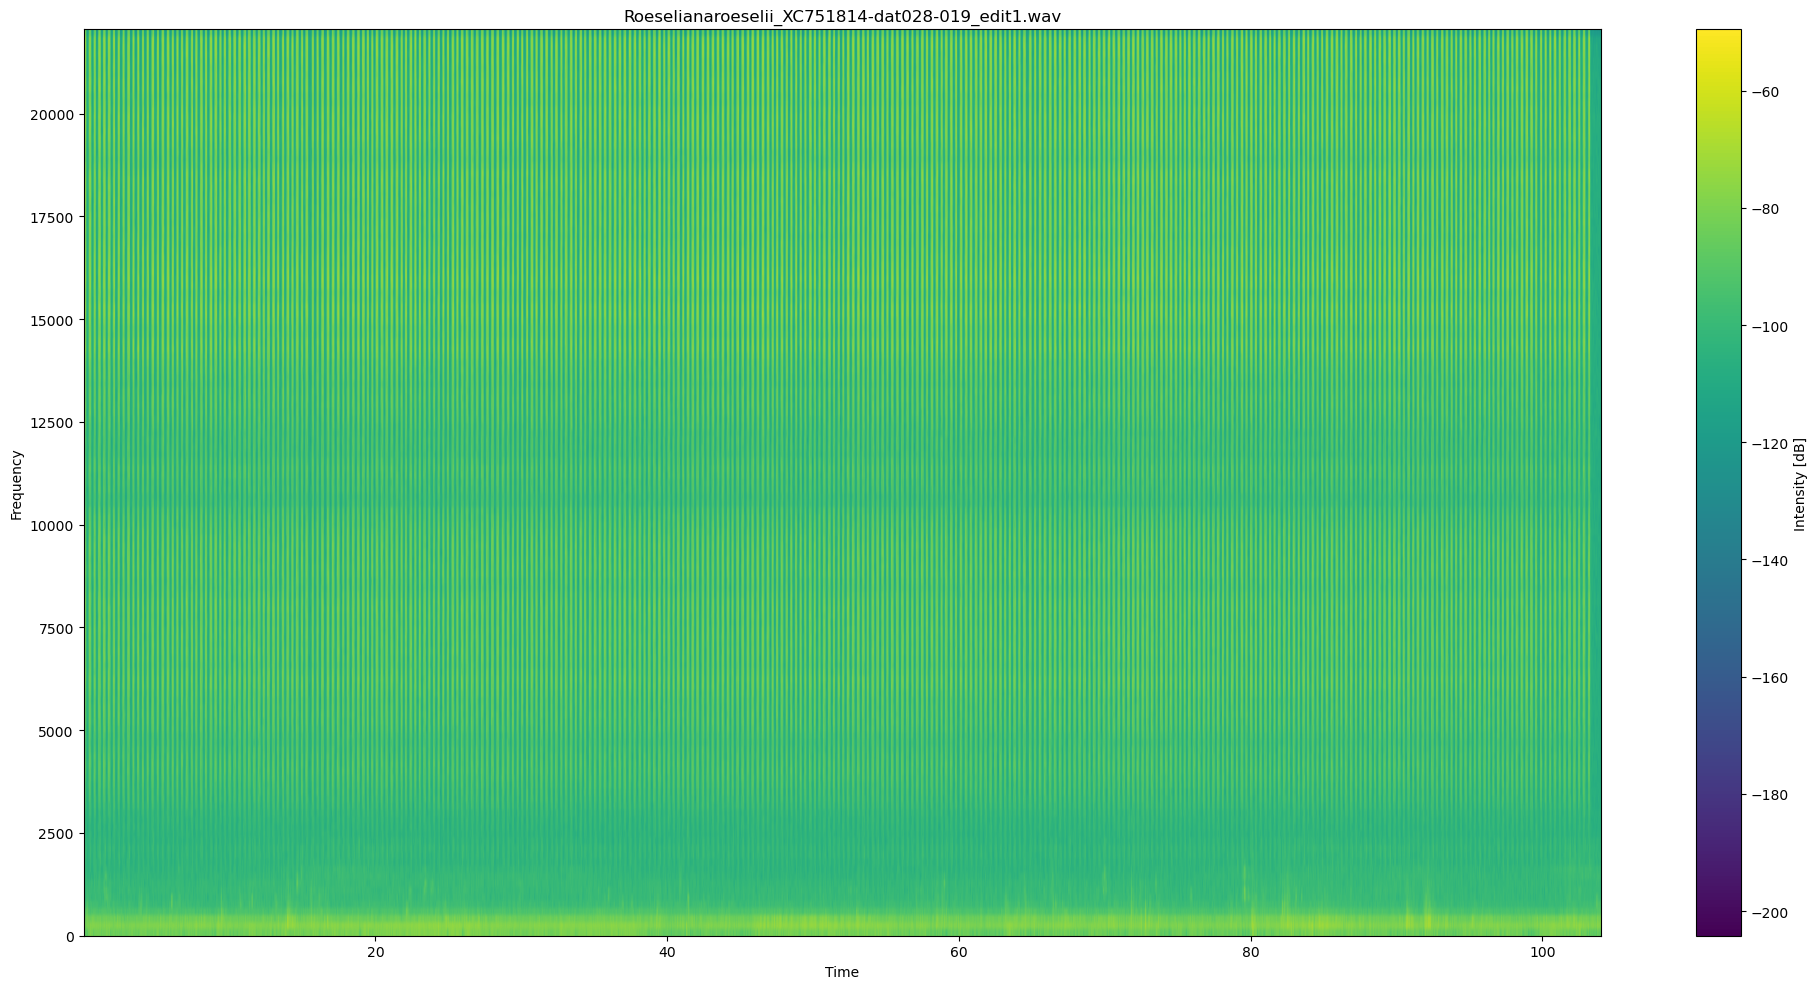

In [5]:
plot_spec([example_path])

We can see, that at the bottom of the spectrogram, there is some kind of bright green strip that's present during the whole recording. It's probably some kind of noise as insects usually operate at relatively high frequencies. You can go back to the previous notebook and see that this "noise strip" is more of a rule than an exception. 

To focus only on the most important frequencies we will remove everything that is below 300 Hz. We will also take only the first 20 seconds (or less in case the file is shorter) of the recording, as this should be sufficient for a baseline solution.

Below you have a function that extracts the most dominant frequency for every audio file. With the help of it, we will process the data as follows:
* first load the recording
* then take the first 20 seconds
* calculate the Fourier Transform to obtain the frequency spectrum 
* then we filter out the noise below 300 Hz
* get the top frequency, which means the frequency with the loudest (with highest amplitude) signal

We do not include the function in the *source* modules, as it's likely you will not need it in other notebooks.

In [6]:
def extract_peak_frequency(path, freq_threshold=300, n_top=1):
    data, sampling_rate = torchaudio.load(path)                                        # loading audio file
    data = data[0,:20*sampling_rate].numpy()                                           # Taking the first 20 seconds as it should be enough to hear insects sound
    fft_data = fft(data)                                                               # calculating fourier transform
    freqs = fftfreq(len(data))                                                         # calculating frequencies 
    freqs = abs(freqs)                                                                 # we are interested in positive numbers only
    index_above = freqs*sampling_rate>freq_threshold                                   # there is a lot of noise near 0 hz, so let's filter out what's below 300Hz, this is a hyperparameter you can play with
    peak_coefficient = np.argpartition(np.abs(fft_data[index_above]), -n_top)[-n_top:] # taking the index for top n values
    peak_freq = freqs[index_above][peak_coefficient]                                   # using the index to find top n frequencies

    return peak_freq * sampling_rate                                                   # We need to multiple it by sampling_rate to get the real frequency values

Let's see how the function works in practice!

In [7]:
example_peak_freq = extract_peak_frequency(example_path, freq_threshold=300, n_top=1)
example_peak_freq

array([21681.4])

Okay, we can see that the top frequency from all frequencies above the threshold of 300 Hz is equal to 21681.4, which supports the claim that the most predominant frequencies for insects lie in higher ranges.

Note that we can customise our function to extract a number of top frequencies. Here is an example with the top 10 frequencies.

In [8]:
example_top_10_freq = extract_peak_frequency(example_path, freq_threshold=300, n_top=10)
example_top_10_freq

array([21787.5 , 21787.5 , 21512.3 , 21512.3 , 20712.4 , 21712.75,
       21681.4 , 20712.4 , 21681.4 , 21712.75])

Great! We can extract even more top frequencies. For our purpose, we will extract only the top one, but please note that you can extract more and use them as features for the model to see if there is any improvement.

Now we will apply our function on our metadata file to create a new feature - the top1 frequency.

In [9]:
# extracting top1 frequencies per file and storing it in a pandas df
df_freqs = df_metadata['path'].progress_apply(lambda x: pd.Series(extract_peak_frequency(x))) 
# joining the metadata df with the top1 frequency dataframe and renaming the column of newly created feature
df_metadata = df_metadata.join(df_freqs).rename({0:'top_frequency'}, axis = 1)

  0%|          | 0/2331 [00:00<?, ?it/s]

Let's inspect the results below. We can see that our metadata data frame has now one more column at the end called *top_frequency*. It's values show the top frequency extracted from the respective recording.

In [10]:
df_metadata.head()

file_name   
0   Roeselianaroeselii_XC751814-dat028-019_edit1.wav  \
1         Roeselianaroeselii_XC752367-dat006-010.wav   
2   Yoyettacelis_GBIF2465208563_IN36000894_50988.wav   
3        Gomphocerippusrufus_XC752285-dat001-045.wav   
4  Atrapsaltacorticina_GBIF2901504947_IN62966536_...   

                                         unique_file   
0             Roeselianaroeselii_XC751814-dat028-019  \
1             Roeselianaroeselii_XC752367-dat006-010   
2       Yoyettacelis_GBIF2465208563_IN36000894_50988   
3            Gomphocerippusrufus_XC752285-dat001-045   
4  Atrapsaltacorticina_GBIF2901504947_IN62966536_...   

                                                path              species   
0  data/train/Roeselianaroeselii_XC751814-dat028-...   Roeselianaroeselii  \
1  data/train/Roeselianaroeselii_XC752367-dat006-...   Roeselianaroeselii   
2  data/train/Yoyettacelis_GBIF2465208563_IN36000...         Yoyettacelis   
3  data/train/Gomphocerippusrufus_XC752285-dat001...  Gomphocerippusrufus   
4  data/val/Atrapsaltacorticina_GBIF2901504947_IN...  Atrapsaltacorticina   

   label      subset  sample_rate  num_frames      length  top_frequency  
0     56       train        44100     4586400  104.000000   21681.400000  
1     56       train        44100      337571    7.654671   14937.023026  
2     64       train        44100      220500    5.000000   11859.400000  
3     26       train        44100      693715   15.730499    8921.141103  
4      3  validation        44100      502740   11.400000   10417.280702

As in the last notebook, we can use *.describe* to get a basic understanding of this new feature.

In [11]:
df_metadata.loc[:, "top_frequency"].describe()

count     2331.000000
mean     10255.965027
std       5749.487049
min        300.050000
25%       6549.525000
50%       9653.956044
75%      14658.750000
max      22047.700000
Name: top_frequency, dtype: float64

The range of frequencies is between 300 (our cut-off point) and around 22047. But what's more interesting is the frequency distribution between classes. A big difference between classes would tell us, that indeed, there's some discriminative power in our new variable. A [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) will help us check if tis is the case.

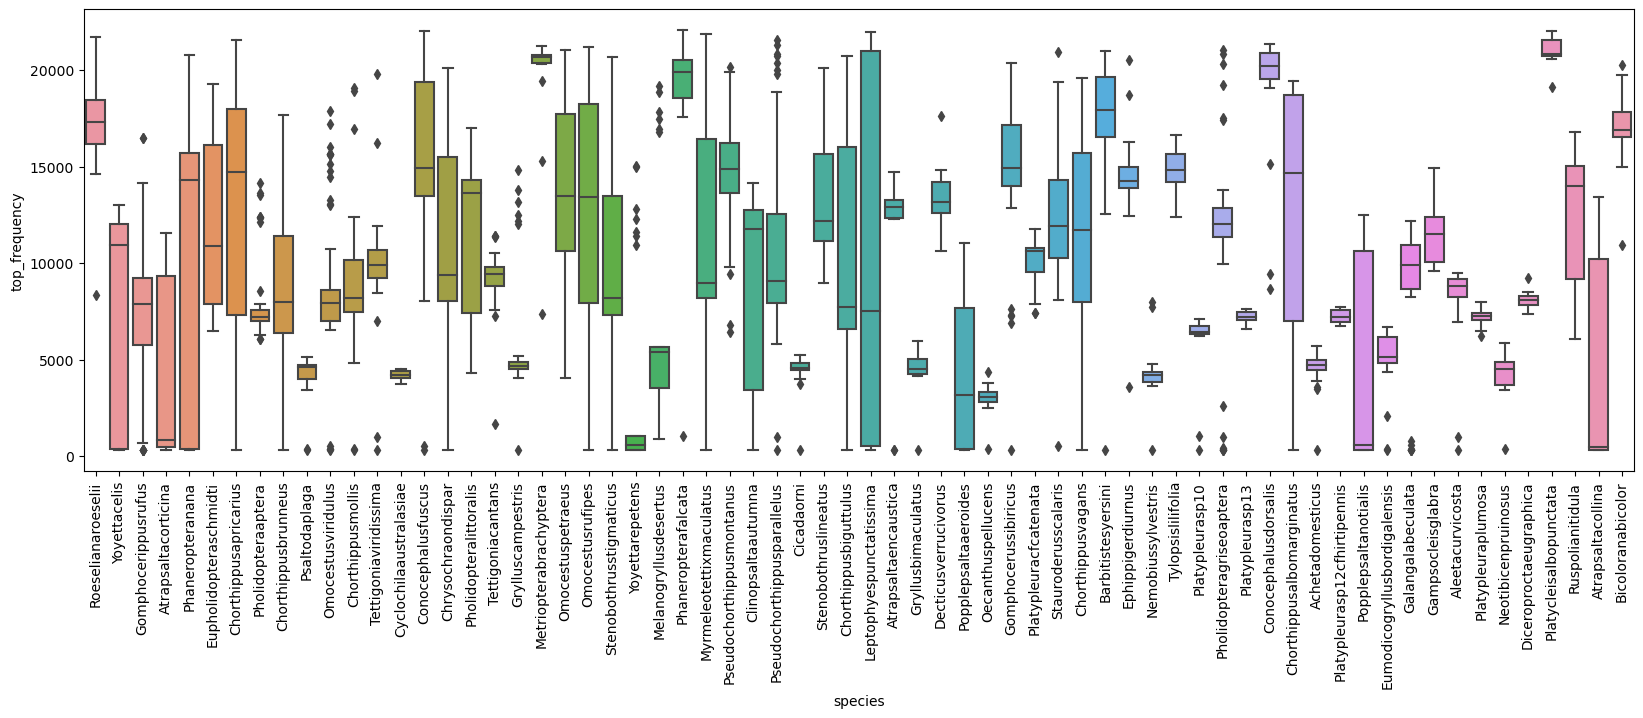

In [12]:
plt.figure(figsize = (20,6))
sns.boxplot(data = df_metadata, x = 'species', y = "top_frequency")
plt.xticks(rotation = 90)
plt.show()

We can see from the above plot that there are some differences in frequencies per class. Hence we can use this to build a first model. It will probably not be great but establish a baseline that we can later improve upon.

**Key insights**
* Insects operate in high-frequency ranges
* The top frequencies between classes vary, which may be helpful to distinguish them from one another

**Exercises:**

Prepare a separate dataset with:
- one feature - top 1 frequency, but with freq_threshold set to 0
- ten features - top 10 frequencies, with freq_threshold set to 300
- think of other important features that you may include in the model and add them to a separate dataset.

Save all the datasets for later. We gonna ask you to run a model on them, submit the results and compare the different preprocessing steps that you used.

## Our first model!

Having our dataset ready let's finally prepare a baseline model. For this purpose, we will need to import a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from [scikit-learn](https://scikit-learn.org/stable/), a go-to library for creating Machine Learning models.

In [13]:
from sklearn.ensemble import RandomForestClassifier # importing our first model from the sklearn library

Before modeling, we need to split the dataset into training and validation subsets. Usually, this is done via "splitters" like [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit), but in our case we can just use the split that is already provided in the metadata.

In [14]:
df_train = df_metadata[df_metadata['subset']=='train']
df_val = df_metadata[df_metadata['subset']=='validation']

Now we need to create numpy arrays that will contain: the data for training (denoted as X_train), labels of the training data (denoted as y_train), the data for evaluation (denoted as X_val), and the labels of the validation set (denoted as y_val). 

In [15]:
X_train = df_train[['top_frequency']].values
y_train = df_train['label'].values
X_val = df_val[['top_frequency']].values
y_val = df_val['label'].values

Let's instantiate our classifier. With the magic of scikit-learn, it is as simple as writing one line of code! We set the random_state parameter to 42, to have reproducible results.

In [16]:
rfc = RandomForestClassifier(random_state = 42)

The last thing to do for the modeling part is to invoke the method fit on our classifier and pass the train set and its labels so that the model can "learn" how to predict the species.

In [17]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

And done! We just trained our first model! Let's create the predictions of the model on the validation set.

In [18]:
preds = rfc.predict(X_val)

In [19]:
preds

array([61, 56,  0, 19, 54,  0, 42, 54, 42, 11, 34, 29, 27, 10, 64, 24, 64,
       11, 11,  0,  2, 39, 60, 56, 24, 45, 41, 25,  4, 13, 19, 43, 40, 37,
       39,  9, 17, 39, 24, 64, 39, 61, 46, 11,  8, 28, 23, 30, 33, 42, 39,
       11,  2, 61, 52, 64, 15, 39, 30, 19, 65, 11,  9, 59, 64,  9, 49, 48,
        9, 54,  6, 22, 17, 11,  3, 10,  9, 55, 61, 64, 30, 64, 26, 49, 64,
       29, 36, 64, 60, 38, 38, 40, 13, 45, 65, 56, 29, 62, 64,  9, 11,  8,
        9, 40, 29, 12, 16, 44,  9, 64, 10, 54,  6, 37, 64, 64, 39, 61, 59,
       41, 59, 64, 38, 29,  8,  8, 42, 50, 34, 53, 12, 62, 27,  5, 60, 29,
       37, 38, 45, 59, 55,  9, 60, 59,  6, 33, 61, 39, 38, 64, 62,  6, 56,
       13, 33, 42, 42, 57, 33, 55, 33,  1, 33,  9, 64, 60, 13, 64, 11,  8,
        9, 15, 64, 42, 63, 17, 26, 31, 33, 21, 23, 64, 17, 29, 65,  7, 61,
       14, 61, 58,  2, 43, 25, 64, 60,  8, 64,  1, 38, 61,  0, 62, 44,  2,
       42, 59, 64, 61, 27, 44,  9, 43, 28, 64, 45,  5, 65, 42, 56, 38, 46,
       37, 41, 39,  6, 12

We just created a vector with all the predicted labels for our validation set. 

But how do we know that it is good? We need to evaluate it!

**Key insights:**
* instantiating and training models in scikit-learn is really easy!
* the library provides a range of different machine learning models, if this is your first encounter with the library, [go ahead and inspect other possibilities](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for building models

## Evaluation

For this year's challenge, we decided to use the macro averaged [F1-score](https://en.wikipedia.org/wiki/F-score), to assess how well your models perform. To understand the macro averaged F1-score let's first look at two other important classification metrics - [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

The easiest way to explain everything would be to take an example of a binary classification. This is a task where we only have two classes and one of them is denoted as "1" (or positive) and the other as "0" (or negative). In this kind of task, any classifier can predict a label either correctly or not. Taking into account the information about the actual labels we basically have these four scenarios:
1. The positive class label was assigned correctly - we call it a True Positive (TP)
2. The positive class label was assigned incorrectly - we call it a False Positive (FP)
3. The negative class label was assigned correctly - we call it a True Negative (TN)
4. The negative class label was assigned incorrectly - we call it a False Negative (FN)

The **precision** of a classifier is defined as:
$$
precision= \frac{TP}{TP+FP}
$$

And the **recall** as:
$$
recall= \frac{TP}{TP+FN}
$$

To put it more simply the precision of a classifier tells us how many true positive predictions we have in the set of all positive predictions of the model. The recall on the other hand tells us how many true positive predictions we have in the set of all positive examples in the dataset.

A metric that combines the information about precision and recall is called **F1-score** and is defined as:
$$
F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}
$$

which means, that it is a harmonic mean of those two.

Hopefully, we have now an understanding of what the F1-score is, but we need to see how that translates to our multiclass scenario.

In a multiclass classification task, the F1 score is usually calculated for each class separately, by treating that class as the positive class and the remaining classes as the negative class. Once these "partial" F1 scores are calculated we need to somehow aggregate them. In the *macro averaged* scenario we simply take the arithmetic mean of all the "partial" F1-scores and obtain a single value. This value will determine your place on the leaderboard!

***
**Exercise**:

Another important metric in classification tasks is **accuracy** - if you've never heard of it try to make research and understand it. Would it be a good metric for our task? Post your thoughts on the Teams channel!
***
Let's now calculate those metrics in Python. For this, we need to make relevant imports from the scikit-learn library, which may help us to understand how well (or badly) are we performing.

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 

# Recall that y_val contains the *truth* and preds the predictions of our model
precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average="macro")
acc = accuracy_score(y_val, preds)

print(f'precision: {precision:.2f}\nrecall: {recall:.2f}\nf1-score:{f1:.2f}\naccuracy: {acc:.2f}')

precision: 0.09
recall: 0.08
f1-score:0.08
accuracy: 0.11


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ouch! Taking into account that all of those metrics range between 0 (everything is wrong) and 1 (everything is correct) we can see that our first model is not generating good results. Nevertheless, let's examine the results on the test set.

**Key insights:**
* There is a variety of metrics used for measuring a classifier
* For the purpose of this challenge your models will be evaluated based on the F1-score

**Exercise:**
There are a few other options for baseline models:

- A model that always predicts the most frequent class
- A model that randomly picks any of the existing classes

Implement them and compare the results!

## Our first submission!

Let us create a first submission that we can upload on the [GDSC webpage](https://gdsc.ce.capgemini.com/) and see our score on the leaderboard. First, we need to read the test metadata, to have the paths for extracting peak frequency from the wav files.

In [21]:
test_metadata_df = pd.read_csv("data/test/metadata.csv")
test_metadata_df.head()

file_name
0     0.wav
1     1.wav
2     2.wav
3     3.wav
4     4.wav

Like previously we need to use the extract_peak_frequency function to get the top frequency for each file, but we need to add the path to the files, so that we can load them and pass through the function.

In [22]:
test_metadata_df['file_name'] = test_metadata_df['file_name'].apply(lambda x: f'data/test/{x}')
test_metadata_df.head()

file_name
0  data/test/0.wav
1  data/test/1.wav
2  data/test/2.wav
3  data/test/3.wav
4  data/test/4.wav

Done! Now we can pass the data through our function:

In [23]:
# extracting top1 frequencies per file and storing it in a pandas df
df_freqs_test = test_metadata_df['file_name'].progress_apply(lambda x: pd.Series(extract_peak_frequency(x))) 
# joining the metadata df with the top1 frequency dataframe and renaming the column of newly created feature
test_metadata_df = test_metadata_df.join(df_freqs_test).rename({0:'top_frequency'}, axis = 1)

  0%|          | 0/556 [00:00<?, ?it/s]

Now we need to get the newly created feature in the form of a numpy array.

In [24]:
X_test = test_metadata_df[["top_frequency"]].values

And do predictions with our previously trained model.

In [25]:
preds_test = rfc.predict(X_test)

Done! Let's see the vector of test set predictions.

In [26]:
preds_test

array([34, 12, 39, 63, 10, 54,  7, 17, 11, 44, 26, 46, 14, 47, 29, 10, 21,
       36, 36, 29, 23, 41, 10, 40, 12, 31, 64,  9, 35, 41, 37, 12, 13,  1,
        9, 40,  6, 24, 12, 55, 55, 59,  8, 17, 62, 39, 38, 38, 33, 56, 12,
       10, 65, 52, 12, 61, 42, 52, 34, 54,  8,  8, 52, 59, 11, 19, 38,  3,
       60, 12, 33, 17, 38, 29, 27, 34, 56, 44, 32, 29, 29, 17,  5, 11, 32,
       64, 12, 17, 15, 37, 56, 25, 40, 15, 51, 17, 55, 33, 38, 65,  5, 54,
        8, 13, 14, 19,  5, 54, 37, 62, 25, 55, 55, 39,  5, 59, 41, 63, 44,
       56, 23,  8, 60, 17, 65,  8, 25, 60, 42, 37, 31, 19, 44, 63,  8, 39,
       40, 10, 28, 54,  9, 12, 26, 21,  1, 33, 26, 22, 38, 56, 36, 10, 52,
       44, 11, 64, 46,  9, 38, 55, 12, 40, 31, 45, 45, 30, 60, 39, 27, 61,
       44, 62, 59,  8, 27, 50, 55, 17, 27, 63, 61, 12, 54, 11,  9, 19, 21,
       25, 64, 29, 54, 12, 49, 64, 15, 58, 23, 29, 36,  0, 54, 27, 64, 58,
       61, 24, 10, 11, 40, 60, 53, 22, 61, 60, 61, 55, 56,  9,  9, 61,  1,
       10, 47, 63, 33, 10

Everything looks good! We need to add this vector to our test_metadata_df and leave only the columns: **file_name** and **predicted_class_id**. The rest of the columns are redundant. The last step is to save the CSV file in the appropriate location.

***
**It is important that you name the columns exactly like that, otherwise your score won't appear on the leaderboard!**
***

For this model, we created in the **models** folder the **RandomForestClassifier** subfolder. Let's run the remaining cells to save the CSV file in the appropriate form and the appropriate location.

In [27]:
# creating the column with predictions
test_metadata_df['predicted_class_id'] = preds_test

In [ ]:
# we can see that there is one reduntant column - top_frequency
test_metadata_df.head()

In [28]:
# let's get rid of the top_frequency column and change paths to file names
test_metadata_df.drop('top_frequency', axis=1, inplace=True)
test_metadata_df['file_name'] = test_metadata_df['file_name'].apply(lambda x: x.split('/')[-1])
test_metadata_df.head()

file_name  predicted_class_id
0     0.wav                  34
1     1.wav                  12
2     2.wav                  39
3     3.wav                  63
4     4.wav                  10

In [29]:
# saving the csv file under the appropriate location. Create the folder if it doesn't exist 
model_folder_path = "models/RandomForestClassifier"
if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)
test_metadata_df[['file_name', 'predicted_class_id']].to_csv(f'{model_folder_path}/predictions.csv', index=False) # Index false ensures that we won't write what we have in the index of our df to the csv - this would add an additional column in the file

And done! We have our CSV file with the predictions ready. Let's upload it via the challenge website and see our results!

The score seems to be a bit discouraging ðŸ˜Ÿ But don't worry, you surely can improve this baseline model by doing the following exercise!

**Key insights:**
* If you want your score to be calculated with our backend functions please be sure to save the file with the predictions with exactly two columns - *file_name* and *predicted_class_id*, otherwise we won't be able to process it
* A Random Forest although being a great model is probably not the best one if you aim to win the GDSC, especially if we pass only one feature...

**Exercise:**

The last exercise in this notebook is to try to improve our results from the initial modeling. Hopefully, by now you have prepared your other datasets from the first exercise. Try to fit the same model on the data and see the results. What are the different parameters of the random forest model, inspect the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and try to tweak some hyperparameters. Inspect also the scikit-learn library and try out other models!

***
In the next tutorial we'll be using a more advanced and more state-of-the-art algorithm, so stay tuned and in the meantime make sure you understood the metrics used for this challenge! 

**REMINDER**: After finishing your work remember to shut down the instance.